In [1]:
import sys

sys.path.append("../")

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import torch
import anndata as ad
#sys.path.append('/home/exx/git/Tangram/')  # uncomment for local import
#import telegraph as tg
import pyreadr

%load_ext autoreload
%autoreload 2
%matplotlib inline

#tg.__version__

/gstore/home/huangh83/miniconda3/envs/tangram/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
REAL_DATA_SC_PTH = '/gstore/data/resbioai/tangram2_data/telegraph/res/ccc_data/original_dataset/scc_new.h5ad'
ad_sc_all = ad.read_h5ad(REAL_DATA_SC_PTH)

In [4]:
folder = '/gstore/data/resbioai/tangram2_data/telegraph/res/ccc_eval/real/scc_dataset/cci/all_to_one/level2_mod/'#'Tcell_major/'
patient = list(ad_sc_all.obs['patient'].unique())

In [5]:
DE_gene = []
for i in patient:
    DE_gene.append(pd.read_csv(folder+ i + '.csv', index_col=0))

In [7]:
#T_minor = ['NK cells']#list(ad_sc_all[ad_sc_all.obs.celltype_major == 'T-cells'].obs.celltype_mod.unique())#['T cells CD8+']#list(ad_sc_all[ad_sc_all.obs.celltype_major == 'T-cells'].obs.celltype_mod.unique())
receiver = [ 'T-cell', 'Fibroblast', 'Endothelial', 'DC',  'Macrophage']
signaler = ['TSK', 'Fibroblast', 'Endothelial', 'DC',  'Macrophage'] #['PDL1_cancer', 'Cancer Epithelial'] #['PDL1_Macrophage', 'Macrophage'] # + cancer_subtype #, 'Macrophage']# cancer_subtype + ['PDL1_cancer']

In [8]:
interaction = []
for i in receiver:
    for j in signaler:
        interaction.append(i + '_vs_' + j)

In [9]:
result = dict()
#marker =  ['lag3', 'tigit', 'ctla4', 'pdcd1', 'havcr2'] #ifn_gene# , 'btla4'

immune_supression =  ['lilrb2', 'tnfrsf14', 'cd276', 'lilrb4', 'c10orf54', 'cd274', 'pdcd1lg2', 'lgals9', 'tdo2', 'ido1' ]
inhibitory =  ['entpd1', 'tigit', 'btla', 'lag3', 'layn',  'ctla4', 'pdcd1', 'havcr2', 'klrc1']

marker = immune_supression + inhibitory

for interact in interaction:
    comparison_df = pd.DataFrame()
    for i in range(len(DE_gene)):
        beta = DE_gene[i].copy() 
        result_temp = beta[(beta.inter == interact) * (beta.features.isin(marker))]
        result_temp['patient'] = patient[i]
        comparison_df = pd.concat([comparison_df, result_temp])
            
    result[interact] = comparison_df.copy()

/local/6301955/ipykernel_6600/3535134135.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_temp['patient'] = patient[i]
/local/6301955/ipykernel_6600/3535134135.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_temp['patient'] = patient[i]
/local/6301955/ipykernel_6600/3535134135.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [10]:
result_df = pd.DataFrame()

for key in result.keys():
    result_df = pd.concat([result_df, result[key]])

In [11]:
result_df2 = result_df.copy()
result_df2.index = result_df2.features

In [30]:
celltype = 'T-cell'
comparison_df = pd.DataFrame()
for pat in result_df2['patient'].unique():
    positive = result_df2[(result_df2['inter'] == celltype + '_vs_DC') * 
                      (result_df2['patient'] == pat)]['beta']
    
    
    comparison_df[pat] = positive #-  negative

In [47]:
gene_list = immune_supression
#celltype = 'T cells CD4+'
#celltype2 = 'PDL1_myeloid'
comparison_df_fibro = pd.DataFrame()
comparison_df_mac = pd.DataFrame()
comparison_df_dc = pd.DataFrame()
comparison_df_endo = pd.DataFrame()
for pat in result_df2['patient'].unique():
    fibro = result_df2[(result_df2['inter'] == 'Fibroblast_vs_TSK') * 
                      (result_df2['patient'] == pat)]['beta']
    mac = result_df2[(result_df2['inter'] == 'Macrophage_vs_TSK') * 
                      (result_df2['patient'] == pat)]['beta']
    dc = result_df2[(result_df2['inter'] == 'DC_vs_TSK') * 
                      (result_df2['patient'] == pat)]['beta']   
    endo = result_df2[(result_df2['inter'] == 'Endothelial_vs_TSK') * 
                      (result_df2['patient'] == pat)]['beta'] 

    comparison_df_fibro[pat] = fibro
    comparison_df_mac[pat] = mac
    comparison_df_dc[pat] = dc
    comparison_df_endo[pat] = endo

comparison_df = pd.DataFrame(index = comparison_df_fibro.index, 
                             columns = ['Fibroblast', 'Macrophage', 'DC'])
comparison_df['Fibroblast'] = comparison_df_fibro.drop([ 'P4'], axis=1).median(axis=1)
comparison_df['Macrophage'] = comparison_df_mac.drop([ 'P4'], axis=1).median(axis=1)
comparison_df['DC'] = comparison_df_endo.drop([ 'P4'], axis=1).median(axis=1)
comparison_df['Endothelial'] = comparison_df_dc.drop([ 'P4'], axis=1).median(axis=1)

In [48]:
# celltype = 'T-cell'
comparison_df.index = comparison_df.index.str.upper()
comparison_df = comparison_df.rename(index={'C10ORF54': 'C10orf54'})


comparison_set = [ i.upper() for i in gene_list]
comparison_set = ['C10orf54' if x == 'C10ORF54' else x for x in comparison_set]

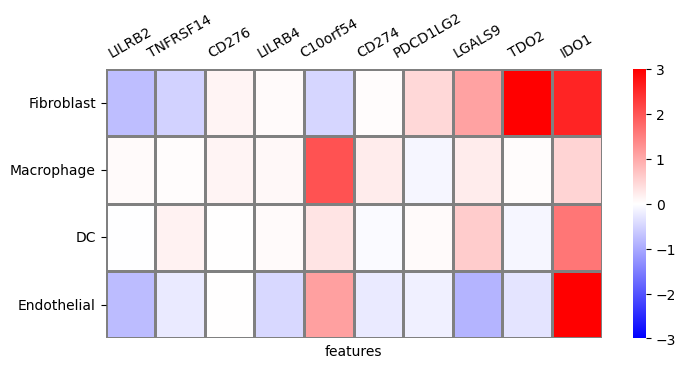

In [49]:
plt.figure(figsize=(8, 3.5)) #, dpi=80)

sns.heatmap(comparison_df.loc[comparison_set].T, cmap = 'bwr', center = 0, vmin = -3.0, vmax = 3.0, linewidths=1, linecolor='grey',)
plt.yticks(rotation = 0)
plt.xticks(fontsize = 18, rotation = 45)
#plt.xticks(fontsize = 18)
plt.tick_params(labelbottom = False, bottom=False, top = False, labeltop=True)
plt.xticks(rotation = 30)
plt.show()

In [50]:
gene_list = inhibitory
#celltype = 'T cells CD4+'
#celltype2 = 'PDL1_myeloid'
comparison_df_fibro = pd.DataFrame()
comparison_df_mac = pd.DataFrame()
comparison_df_dc = pd.DataFrame()
comparison_df_endo = pd.DataFrame()
comparison_df_tsk = pd.DataFrame()
for pat in result_df2['patient'].unique():
    fibro = result_df2[(result_df2['inter'] == 'T-cell_vs_Fibroblast') * 
                      (result_df2['patient'] == pat)]['beta']
    mac = result_df2[(result_df2['inter'] == 'T-cell_vs_Macrophage') * 
                      (result_df2['patient'] == pat)]['beta']
    dc = result_df2[(result_df2['inter'] == 'T-cell_vs_DC') * 
                      (result_df2['patient'] == pat)]['beta']   
    endo = result_df2[(result_df2['inter'] == 'T-cell_vs_Endothelial') * 
                      (result_df2['patient'] == pat)]['beta'] 
    tsk = result_df2[(result_df2['inter'] == 'T-cell_vs_TSK') * 
                      (result_df2['patient'] == pat)]['beta'] 

    comparison_df_fibro[pat] = fibro
    comparison_df_mac[pat] = mac
    comparison_df_dc[pat] = dc
    comparison_df_endo[pat] = endo
    comparison_df_tsk[pat] = tsk

comparison_df = pd.DataFrame(index = comparison_df_fibro.index, 
                             columns = ['Fibroblast', 'Macrophage', 'DC'])
comparison_df['Fibroblast'] = comparison_df_fibro.drop([ 'P4'], axis=1).median(axis=1)
comparison_df['Macrophage'] = comparison_df_mac.drop([ 'P4'], axis=1).median(axis=1)
comparison_df['DC'] = comparison_df_endo.drop([ 'P4'], axis=1).median(axis=1)
comparison_df['Endothelial'] = comparison_df_dc.drop([ 'P4'], axis=1).median(axis=1)
comparison_df['TSK'] = comparison_df_tsk.drop([ 'P4'], axis=1).median(axis=1)

In [51]:
# celltype = 'T-cell'
comparison_df.index = comparison_df.index.str.upper()
comparison_df = comparison_df.rename(index={'C10ORF54': 'C10orf54'})


comparison_set = [ i.upper() for i in gene_list]
comparison_set = ['C10orf54' if x == 'C10ORF54' else x for x in comparison_set]

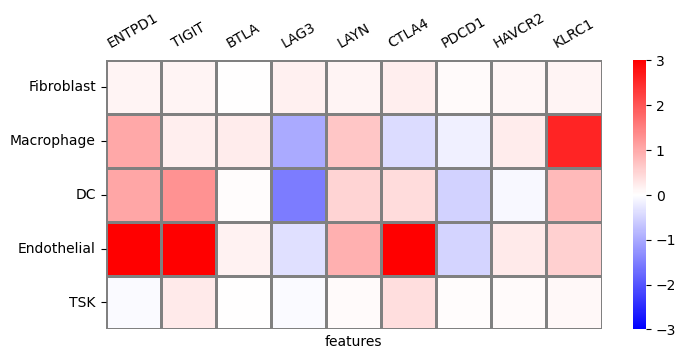

In [52]:
plt.figure(figsize=(8, 3.5)) #, dpi=80)

sns.heatmap(comparison_df.loc[comparison_set].T, cmap = 'bwr', center = 0, vmin = -3.0, vmax = 3.0, linewidths=1, linecolor='grey',)
plt.yticks(rotation = 0)
plt.xticks(fontsize = 18, rotation = 45)
#plt.xticks(fontsize = 18)
plt.tick_params(labelbottom = False, bottom=False, top = False, labeltop=True)
plt.xticks(rotation = 30)
plt.show()